In [60]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt

%matplotlib inline 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error

### Week 6: Homework

Preperation

In [32]:
data = pd.read_csv(r'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv').query('ocean_proximity in ["<1H OCEAN", "INLAND"]')

In [33]:
data = data.fillna(0)

In [34]:
data.median_house_value = np.log1p(data.median_house_value)

In [35]:
#train val test split
data_full_train, data_test = train_test_split(data, test_size=0.2, random_state=1)
data_train, data_val = train_test_split(data_full_train, test_size=0.25, random_state=1)

In [36]:
#create X and y dataframes
dv = DictVectorizer(sparse=False)

y_train = data_train.median_house_value.values
del data_train['median_house_value']

X_train = dv.fit_transform(data_train.to_dict(orient='records'))

y_val = data_val.median_house_value.values
del data_val['median_house_value']

X_val = dv.transform(data_val.to_dict(orient='records'))

y_test = data_test.median_house_value
del data_test['median_house_value']

X_test = dv.transform(data_test.to_dict(orient='records'))

### Question 1

In [47]:
tree_model = DecisionTreeRegressor(max_depth=1)

tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [48]:
print(export_text(tree_model, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [46]:
print("The feature used for splitting the data is: ocean_proximity.")

The feature used for splitting the data is: ocean_proximity.


### Question 2

In [51]:
rf_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

print(round(mean_squared_error(y_val, y_pred, squared=False), 3))


0.245


### Question 3

In [58]:
score_lst = []

for n in np.arange(start=10, stop=201, step=10):
    rf_model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    rmse_score = mean_squared_error(y_val, y_pred, squared=False)

    score_lst.append((n, rmse_score))




In [59]:
df_scores = pd.DataFrame(score_lst ,columns=['n_estimators','rmse_score'])

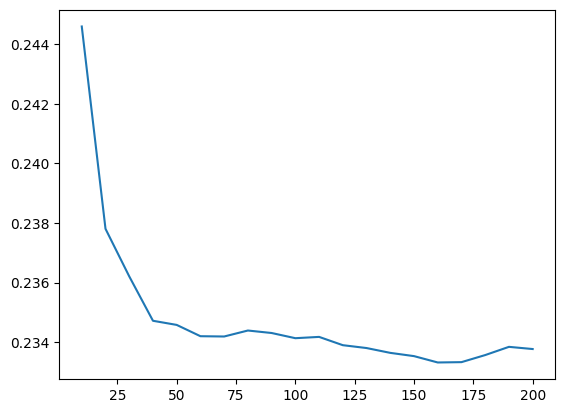

In [61]:
plt.plot(df_scores.n_estimators, df_scores.rmse_score)

In [64]:
df_scores[df_scores['rmse_score'] == df_scores['rmse_score'].min()]

,n_estimators,rmse_score
15,160,0.233315


### Question 4

In [67]:
max_depth_score_lst = []

for max_depth in np.arange(start=10, stop=26, step=5):
    n_scores = []
    for n in np.arange(start=10, stop=201, step=10):
        rf_model = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)

        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_val)

        rmse_score = mean_squared_error(y_val, y_pred, squared=False)

        n_scores.append(rmse_score)
    
    rmse_mean = np.mean(n_scores)
    max_depth_score_lst.append((max_depth, rmse_mean))
    




In [68]:
df_scores = pd.DataFrame(max_depth_score_lst, columns=['max_depth', 'mean_rmse'])

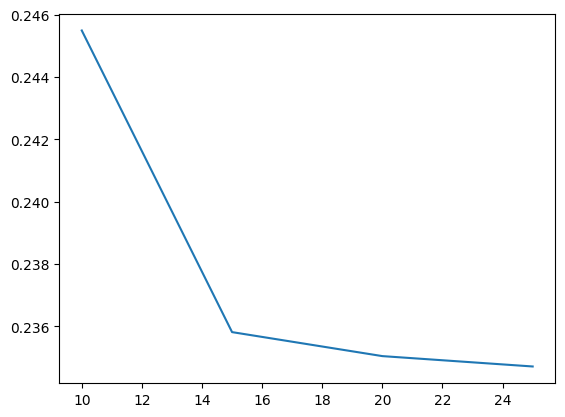

In [69]:
plt.plot(df_scores.max_depth, df_scores.mean_rmse)

### Question 5

In [70]:
dt_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

dt_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [82]:
feat_importance = dict(zip(dv.get_feature_names_out(), dt_model.feature_importances_))

In [83]:
max(feat_importance,  key= lambda x: feat_importance[x])

'median_income'

### Question 6

In [84]:
import xgboost as xgb

In [88]:
data = pd.read_csv(r'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv').query('ocean_proximity in ["<1H OCEAN", "INLAND"]')
data = data.fillna(0)
data.median_house_value = np.log1p(data.median_house_value)

data = data.replace({'<1H OCEAN': '1H OCEAN'})

#train val test split
data_full_train, data_test = train_test_split(data, test_size=0.2, random_state=1)
data_train, data_val = train_test_split(data_full_train, test_size=0.25, random_state=1)


#create X and y dataframes
dv = DictVectorizer(sparse=False)

y_train = data_train.median_house_value.values
del data_train['median_house_value']

X_train = dv.fit_transform(data_train.to_dict(orient='records'))

y_val = data_val.median_house_value.values
del data_val['median_house_value']

X_val = dv.transform(data_val.to_dict(orient='records'))

y_test = data_test.median_house_value
del data_test['median_house_value']

X_test = dv.transform(data_test.to_dict(orient='records'))


In [89]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names = list(features))
dval = xgb.DMatrix(X_val, label=y_val, feature_names = list(features))

In [92]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [91]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=5)

[0]	train-rmse:0.44350	val-rmse:0.44250
[5]	train-rmse:0.25338	val-rmse:0.27463
[10]	train-rmse:0.21444	val-rmse:0.25179
[15]	train-rmse:0.19858	val-rmse:0.24522
[20]	train-rmse:0.18524	val-rmse:0.23978
[25]	train-rmse:0.17757	val-rmse:0.23830
[30]	train-rmse:0.16888	val-rmse:0.23570
[35]	train-rmse:0.16113	val-rmse:0.23416
[40]	train-rmse:0.15542	val-rmse:0.23318
[45]	train-rmse:0.14941	val-rmse:0.23190
[50]	train-rmse:0.14536	val-rmse:0.23225
[55]	train-rmse:0.14150	val-rmse:0.23197
[60]	train-rmse:0.13719	val-rmse:0.23139
[65]	train-rmse:0.13259	val-rmse:0.23158
[70]	train-rmse:0.12943	val-rmse:0.23068
[75]	train-rmse:0.12555	val-rmse:0.23039
[80]	train-rmse:0.12192	val-rmse:0.22886
[85]	train-rmse:0.11854	val-rmse:0.22888
[90]	train-rmse:0.11496	val-rmse:0.22861
[95]	train-rmse:0.11211	val-rmse:0.22908
[99]	train-rmse:0.10989	val-rmse:0.22862


In [94]:
y_pred = model.predict(dval)

scores['0.3'] = mean_squared_error(y_val, y_pred, squared=False)



In [95]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=5)

[0]	train-rmse:0.52449	val-rmse:0.52045
[5]	train-rmse:0.37822	val-rmse:0.38151
[10]	train-rmse:0.30326	val-rmse:0.31427
[15]	train-rmse:0.26538	val-rmse:0.28380
[20]	train-rmse:0.24512	val-rmse:0.26882
[25]	train-rmse:0.23026	val-rmse:0.25997
[30]	train-rmse:0.21887	val-rmse:0.25266
[35]	train-rmse:0.21020	val-rmse:0.24826
[40]	train-rmse:0.20392	val-rmse:0.24539
[45]	train-rmse:0.19814	val-rmse:0.24293
[50]	train-rmse:0.19215	val-rmse:0.24020
[55]	train-rmse:0.18809	val-rmse:0.23878
[60]	train-rmse:0.18457	val-rmse:0.23791
[65]	train-rmse:0.18063	val-rmse:0.23698
[70]	train-rmse:0.17741	val-rmse:0.23622
[75]	train-rmse:0.17468	val-rmse:0.23510
[80]	train-rmse:0.17242	val-rmse:0.23453
[85]	train-rmse:0.17014	val-rmse:0.23404
[90]	train-rmse:0.16797	val-rmse:0.23332
[95]	train-rmse:0.16562	val-rmse:0.23276
[99]	train-rmse:0.16323	val-rmse:0.23209


In [96]:
y_pred = model.predict(dval)

scores['0.1'] = mean_squared_error(y_val, y_pred, squared=False)



In [97]:
scores

{'0.3': 0.228623199980106, '0.1': 0.23208927121609343}